# Tutorial: Perturbation simulation

In this tutorial we illustrate how the predictions from SCENIC+ can be utilized to simulate the effect of transcription factor perturbations.

Here, the predictions of SCENIC+ serve as a feature selection method. We will use the expression of transcription factors (TFs) as predictors for their target gene expression. 
For this a random forest regression model will be fitted for each gene with the expression of TFs which are predicted to regulate them by SCENIC+ as predictor for their target gene expression.
After fitting the models we can alter the expression of a TF of choice and we can simulate a new gene expression matrix. This simulation is repeated for several iterations to simulate indirect effects.
The simulated cells in this new matrix can be projected in an embedding of choice to visualize the effect of the perturbation.

For this tutorial we will continue with the SCENIC+ analysis which he have done in the "Mix of melanoma cell lines" tutorial.

<div class="alert alert-warning">

**Warning:**

In order to continue you need to have the python package `velocyto` installed. 
</div>

In [ ]:
%pip install velocyto

## Setting up work environment

In [1]:
#supress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import sys
import os
work_dir = 'perturbation_simulation'
tmp_dir = '/scratch/leuven/330/vsc33053/'

if not os.path.exists(work_dir):
    os.makedirs(work_dir)

Load the scenicplus object from previous tutorial.

In [14]:
import dill
scplus_obj = dill.load(open('mm_lines/scenicplus/scplus_obj.pkl', 'rb'))

Let's calculate a target gene based PCA embedding to plot the perturbations on

In [21]:
from scenicplus.dimensionality_reduction import run_eRegulons_pca
run_eRegulons_pca(
        scplus_obj,
        auc_key = 'eRegulon_AUC_filtered',
        reduction_name = 'eRegulons_PCA_gene_based',
        selected_regulons = scplus_obj.uns['selected_eRegulons']['Gene_based'])

## Plotting perturbation effect on an embedding

Let's simulate the effect of SOX10 knockdown. In this example of the melanoma cell lines it is known, from previous studies it is known that this perturbation can cause a phenotype swith of melanocytic states towards a more mesenchymal like state.

For the sake of computational time we will only simulate the expression of the top 200 highly variable genes.

You might opt to select more or all features, depending on your analysis

In [16]:
from pycisTopic.diff_features import find_highly_variable_features
hvg = find_highly_variable_features(scplus_obj.to_df('EXP')[list(set(scplus_obj.uns['eRegulon_metadata_filtered']['Gene']))].T, n_top_features = 200, plot = False)

2022-08-11 14:40:22,505 cisTopic     INFO     Calculating mean
2022-08-11 14:40:22,516 cisTopic     INFO     Calculating variance
2022-08-11 14:40:22,661 cisTopic     INFO     Done!


<Figure size 432x288 with 0 Axes>

2022-08-11 14:45:00,881 perturbation INFO     Caclulating perturbation matrix for: {'SOX10': 0} over 5 iterations.


100%|██████████| 199/199 [00:27<00:00,  7.31it/s]


2022-08-11 14:45:35,507 perturbation INFO     Generating ranking based on perturbed matrix.
2022-08-11 14:45:37,668 perturbation INFO     Scoring eRegulons.
2022-08-11 14:45:43,810 perturbation INFO     Projecting perturbation effect in embedding: eRegulons_PCA
2022-08-11 14:45:44,044 perturbation INFO     Calculating grid of arrows
2022-08-11 14:45:44,118 perturbation INFO     Plotting


/lustre1/project/stg_00002/lcb/sdewin/PhD/python_modules/scenicplus/src/scenicplus/simulation.py:292: RuntimeWarning: invalid value encountered in true_divide
  unitary_vectors /= np.linalg.norm(unitary_vectors, ord=2, axis=0)  # divide by L2


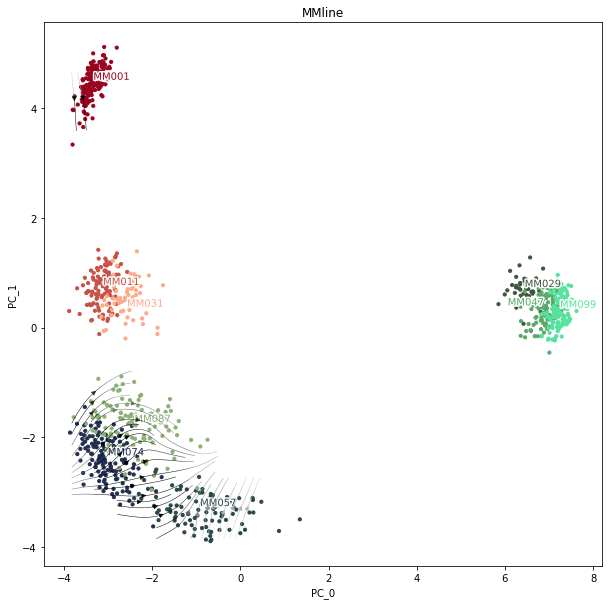

In [22]:
color_dict_line = {
    'MM001': '#9A031E', 
    'MM011': '#C75146', 
    'MM031': '#FFA987',
    'MM074': '#222E50',
    'MM087': '#8BB174',
    'MM057': '#2A4849',
    'MM029': '#3E5641', 
    'MM047': '#59A96A',  
    'MM099': '#56E39F'}

from scenicplus.simulation import plot_perturbation_effect_in_embedding
import seaborn as sns
_ = plot_perturbation_effect_in_embedding(
        scplus_obj = scplus_obj,
        reduction_name = 'eRegulons_PCA_gene_based',
        n_cpu = 5,
        perturbation = {'SOX10': 0}, #specifies that we want to set the expression of SOX10 to 0 in all cells.
        variable = 'MMline',
        color_dictionary = {'MMline': color_dict_line},
        genes_to_use = hvg,
        figsize = (10, 10))

We predict that MM074, MM057 and MM087 (intermidate melanocytic cell state) will move to the right along principle component 0 which in this case corresponds to MEL-MES variation.

## Prioritizing TFs based on their preturbation effect.

We can also make use of the perturbation simulation to prioritize TFs for a certain effect. For example here we want to find TFs which will move cells along principle component 0 (i.e. change their state to a more melanocytic or mesenchymal one).

To do this we need some custom code.

In [23]:
from scenicplus.simulation import *
from scenicplus.simulation import _make_rankings

First we train the gene expression random forrest models (this was previously done in the `plot_perturbation_effect_in_embedding` function).

We will train models for all differentially expressed genes (+ all identified TFs)

In [31]:

flatten_list = lambda t: [item for sublist in t for item in sublist]
DEGs = list(set(flatten_list([list(scplus_obj.uns['DEGs']['lineState'][k].index) for k in scplus_obj.uns['DEGs']['lineState'].keys()])))
genes_to_use = list(set([*DEGs, * [x.split('_')[0] for x in scplus_obj.uns['selected_eRegulons']['Gene_based']]]))

In [ ]:
regressors = train_gene_expression_models(
        scplus_obj,
        eRegulon_metadata_key = 'eRegulon_metadata',
        genes = genes_to_use)

Next we will simulate a knockdown of all identified TFs and recalculate eRegulon enrichment values on the perturbed matrices using AUCell.

In [33]:
#parameters
TFs_of_interest = list(set([x.split('_')[0] for x in scplus_obj.uns['selected_eRegulons']['Gene_based']]))
n_iter = 3

from tqdm.notebook import tqdm
import logging
logging.basicConfig(level=logging.CRITICAL)
import warnings
from scenicplus.eregulon_enrichment import score_eRegulons
from scenicplus.dimensionality_reduction import run_eRegulons_pca
for TF in tqdm(TFs_of_interest, total = len(TFs_of_interest)):
        perturbed_matrices = simulate_perturbation(
                scplus_obj,
                perturbation = {TF: 0},
                regressors = regressors,
                keep_intermediate = True,
                n_iter = n_iter)
        perturbed_rankings = {k: _make_rankings(perturbed_matrices[k]) for k in perturbed_matrices.keys()}
        for k in perturbed_rankings.keys():
                with warnings.catch_warnings():
                        warnings.simplefilter("ignore")
                        score_eRegulons(
                                scplus_obj,
                                ranking = perturbed_rankings[k],
                                eRegulon_signatures_key = 'eRegulon_signatures_filtered',
                                key_added = f'{TF}_KD_sim_eRegulon_AUC_iter_{k}',
                                enrichment_type = 'gene',
                                n_cpu = 5)

  0%|          | 0/49 [00:00<?, ?it/s]

Calculate shift along principle components

In [38]:
from scenicplus.simulation import _project_perturbation_in_embedding
shifts_PC0 = {}
shifts_PC1 = {}
import sys
sys.stderr = open(os.devnull, "w")  # silence stderr    
for TF in TFs_of_interest:
        delta_embedding = _project_perturbation_in_embedding(
                scplus_obj,
                original_matrix = scplus_obj.uns[f'{TF}_KD_sim_eRegulon_AUC_iter_0']['Gene_based'],
                perturbed_matrix = scplus_obj.uns[f'{TF}_KD_sim_eRegulon_AUC_iter_4']['Gene_based'],
                reduction_name = f'{TF}_KD_sim_eRegulons_PCA_iter_0')
        mean_shift = pd.DataFrame(delta_embedding).groupby(scplus_obj.metadata_cell['MMline'].to_numpy()).mean()
        shifts_PC0[TF] = mean_shift[0]
        shifts_PC1[TF] = mean_shift[1]
sys.stderr = sys.__stderr__  # unsilence stderr

Plot factors with a strong effect in a heatmap

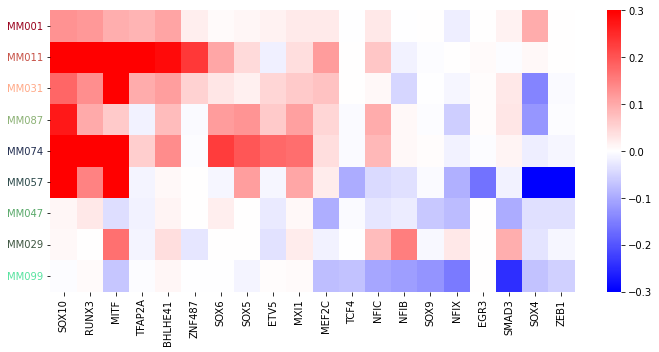

In [43]:
shift_df = pd.DataFrame(shifts_PC0).T
factors_to_plot = [
        *shift_df.max(1).sort_values(ascending = False).head(10).index,
        *reversed(shift_df.min(1).sort_values(ascending = True).head(10).index)]
line_order = ['MM001', 'MM011', 'MM031', 'MM087', 'MM074', 'MM057', 'MM047', 'MM029', 'MM099']
import seaborn as sns
fig, ax = plt.subplots(figsize = (10, 5))
sns.heatmap(
        shift_df.loc[factors_to_plot, line_order].T,
        yticklabels=True,vmin = -0.3, vmax = 0.3, ax = ax, cmap = 'bwr')
for ytick in ax.get_yticklabels():
        ytick.set_color(color_dict_line[ytick.get_text()])
fig.tight_layout()
plt.show(fig)